In [173]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.exporter.xes import exporter as xes_exporter

In [6]:
log = xes_importer.apply('FMP_no_appeal.xes')

In [7]:
df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

In [8]:
traces = df.groupby('case:concept:name')['concept:name'].apply(np.asarray)

In [9]:
last_event = traces.apply(lambda x : x[-1])
last_event.name = 'lastEvent'
df = df.join(last_event,on='case:concept:name')

starttime = df.groupby('case:concept:name')['time:timestamp'].min()
starttime.name = 'starttime'
df = df.join(starttime,on='case:concept:name')

startamount = df.groupby('case:concept:name')['amount'].min()
startamount.name = 'startamount'
df = df.join(startamount,on='case:concept:name')

has_penalty = traces.apply(lambda x : 'Add penalty' in x)
has_penalty.name = 'has_penalty'
df = df.join(has_penalty,on='case:concept:name')

In [10]:
number_cases = len(df['case:concept:name'].unique())
number_credit_collections = len(df[df['lastEvent']=='Send for Credit Collection']['case:concept:name'].unique())
df_no_collect = df[df['lastEvent']!='Send for Credit Collection']
number_credit_collections

58601

In [129]:
toPay = (df_no_collect.groupby('case:concept:name')['amount'].max() +
         df_no_collect.groupby('case:concept:name')['expense'].sum())
payed = df_no_collect.groupby('case:concept:name')['totalPaymentAmount'].max()
balance = toPay - payed

toPay.name = 'toPay'
df = df.join(toPay,on='case:concept:name')

payed.name = 'payed'
df = df.join(payed,on='case:concept:name')

balance.name = 'balance'
df = df.join(balance,on='case:concept:name')

ValueError: columns overlap but no suffix specified: Index(['payed'], dtype='object')

In [36]:
def eval_payment(x):
    
    if x['lastEvent'] == 'Send for Credit Collection':
        return 'exact'
    
    if int(x['balance']) == 0:
        return 'exact'
    
    if x['balance'] < 0:
        return 'over'
    
    if x['payed'] == 0:
        return 'no'
    
    if x['balance'] > 0 and x['payed'] > 0:
        return 'some'

In [39]:
df['outcome'] = df[['lastEvent', 'balance', 'payed']].apply(lambda x : eval_payment(x), axis=1)

In [84]:

exact_payment = len(df[df['outcome']=='exact'].groupby('case:concept:name')) / number_cases

over_payment = len(df[df['outcome']=='over'].groupby('case:concept:name')) / number_cases

no_payment = len(df[df['outcome']=='no'].groupby('case:concept:name')) / number_cases

some_payment = len(df[df['outcome']=='some'].groupby('case:concept:name')) / number_cases

total_deficit = balance.sum()

total_deficit_cleaned = balance[balance>0].sum()

#sanity_check:
print(exact_payment + over_payment + no_payment + some_payment == 1)

print(exact_payment)
print(over_payment)
print(no_payment)
print(some_payment)
print(total_deficit)
print(total_deficit_cleaned)

True
0.8102662196534962
0.005443687995776685
0.139794456213963
0.04449563613676409
1438950.6
1459775.5


In [9]:
df[df['expense']>0]['concept:name'].unique()

array(['Send Fine'], dtype=object)

In [10]:
def count_activity(trace, activity):
    i = 0
    for event in trace:
        if event == activity:
            i += 1
    return i

In [11]:
traces.apply(lambda x : count_activity(x, 'Send Fine')).sum()

99474

In [12]:
len(traces.apply(lambda x : count_activity(x, 'Send Fine')))

145857

In [13]:
import seaborn as sns
sns.distplot(df[df['concept:name']=='Send Fine']['expense'], kde=False)

C:\Users\Sezin\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [14]:
df[df['amount']>0]['concept:name'].unique()

array(['Create Fine', 'Add penalty'], dtype=object)

In [15]:
traces.apply(lambda x : count_activity(x, 'Create Fine')).unique()

array([1], dtype=int64)

In [16]:
traces.apply(lambda x : count_activity(x, 'Add penalty')).unique()

array([0, 1], dtype=int64)

In [115]:
df['diff'] = df['time:timestamp'] - df['starttime']

min 59 days 23:00:00
max 792 days 01:00:00
std 43 days 14:00:20.200169
median 164 days 01:00:00
5         226
10        205
15        185
24        194
29        184
         ... 
531721    114
531726    119
531734    118
531739    114
531744    118
Name: diff, Length: 75503, dtype: int64


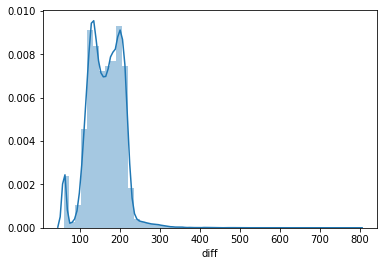

In [49]:
print('min ' + str(df[df['concept:name']=='Add penalty']['diff'].min()))
print('max ' + str(df[df['concept:name']=='Add penalty']['diff'].max()))
print('std ' + str(df[df['concept:name']=='Add penalty']['diff'].std()))
print('median ' + str(df[df['concept:name']=='Add penalty']['diff'].median()))
print(df[df['concept:name']=='Add penalty']['diff'].apply(lambda x : x.days))
sns.distplot(df[df['concept:name']=='Add penalty']['diff'].apply(lambda x : x.days))

In [51]:
df.groupby('points').count()

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,case:concept:name,expense,notificationType,lastSent,paymentAmount,lastEvent,starttime,diff
points,,,,,,,,,,,,,,,,,
0.0,142944,142944,142944,142944,142944,142944,142944,142944,142944,142944,0,0,0,0,142944,142944,142944
1.0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1
2.0,1721,1721,1721,1721,1721,1721,1721,1721,1721,1721,0,0,0,0,1721,1721,1721
3.0,133,133,133,133,133,133,133,133,133,133,0,0,0,0,133,133,133
4.0,11,11,11,11,11,11,11,11,11,11,0,0,0,0,11,11,11
5.0,836,836,836,836,836,836,836,836,836,836,0,0,0,0,836,836,836
6.0,141,141,141,141,141,141,141,141,141,141,0,0,0,0,141,141,141
8.0,18,18,18,18,18,18,18,18,18,18,0,0,0,0,18,18,18
10.0,52,52,52,52,52,52,52,52,52,52,0,0,0,0,52,52,52


In [24]:
df[df['concept:name']=='Add penalty']['case:concept:name']

5           A100
10        A10000
15        A10004
24        A10008
29        A10009
           ...  
531721     V9992
531726     V9995
531734     V9997
531739     V9998
531744     V9999
Name: case:concept:name, Length: 75503, dtype: object

In [27]:
df[df['case:concept:name']=='A100']

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,lastEvent,starttime,diff
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+02:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,Send for Credit Collection,2006-08-02 00:00:00+02:00,0 days 00:00:00
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+01:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,Send for Credit Collection,2006-08-02 00:00:00+02:00,132 days 01:00:00
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+01:00,NaN,NaN,A100,NaN,P,P,NaN,Send for Credit Collection,2006-08-02 00:00:00+02:00,166 days 01:00:00
5,71.5,NaN,NaN,Add penalty,NaN,NaN,complete,2007-03-16 00:00:00+01:00,NaN,NaN,A100,NaN,NaN,NaN,NaN,Send for Credit Collection,2006-08-02 00:00:00+02:00,226 days 01:00:00
6,NaN,NaN,NaN,Send for Credit Collection,NaN,NaN,complete,2009-03-30 00:00:00+02:00,NaN,NaN,A100,NaN,NaN,NaN,NaN,Send for Credit Collection,2006-08-02 00:00:00+02:00,971 days 00:00:00


# Playground


In [20]:
#values that total Payment takes for non Payment events
print(df[df['concept:name']!='Payment']['totalPaymentAmount'].unique())

#values that payment amount takes for non Payment events
print(df[df['concept:name']!='Payment']['paymentAmount'].unique())

[ 0. nan]
[nan]


In [21]:
traces.apply(lambda x : 'Send for Credit Collection' in x[:-1]).any()
#If Send for credit collection appears it is the last event

False

In [82]:
df[df['concept:name']=='Add penalty']['amount'].unique()
df[df['amount']==0]

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,lastEvent,diff,starttime,startamount
78431,0.0,22,NIL,Create Fine,C,0.0,complete,2002-05-21 00:00:00+02:00,171.0,0.0,C11600,NaN,NaN,NaN,NaN,Payment,0 days 00:00:00,2002-05-21 00:00:00+02:00,0.0
79730,0.0,811,NIL,Create Fine,C,0.0,complete,2000-10-11 00:00:00+02:00,171.0,0.0,C12623,NaN,NaN,NaN,NaN,Send Fine,0 days 00:00:00,2000-10-11 00:00:00+02:00,0.0
83566,0.0,831,I,Create Fine,C,0.0,complete,2002-06-01 00:00:00+02:00,171.0,0.0,C14862,NaN,NaN,NaN,NaN,Send Fine,0 days 00:00:00,2002-06-01 00:00:00+02:00,0.0
84318,0.0,46,NIL,Create Fine,A,0.0,complete,2003-09-28 00:00:00+02:00,153.0,0.0,C15288,NaN,NaN,NaN,NaN,Payment,0 days 00:00:00,2003-09-28 00:00:00+02:00,0.0
84321,0.0,NaN,NaN,Add penalty,NaN,NaN,complete,2003-11-27 00:00:00+01:00,NaN,NaN,C15288,NaN,NaN,NaN,NaN,Payment,60 days 01:00:00,2003-09-28 00:00:00+02:00,0.0
86191,0.0,55,NIL,Create Fine,M,0.0,complete,2003-08-27 00:00:00+02:00,180.0,0.0,C16861,NaN,NaN,NaN,NaN,Payment,0 days 00:00:00,2003-08-27 00:00:00+02:00,0.0
86194,0.0,NaN,NaN,Add penalty,NaN,NaN,complete,2003-10-26 00:00:00+02:00,NaN,NaN,C16861,NaN,NaN,NaN,NaN,Payment,60 days 00:00:00,2003-08-27 00:00:00+02:00,0.0
88390,0.0,49,NIL,Create Fine,C,0.0,complete,2005-11-03 00:00:00+01:00,171.0,0.0,C18355,NaN,NaN,NaN,NaN,Send Fine,0 days 00:00:00,2005-11-03 00:00:00+01:00,0.0
88612,0.0,46,NIL,Create Fine,A,0.0,complete,2006-04-19 00:00:00+02:00,218.0,0.0,C18500,NaN,NaN,NaN,NaN,Send Fine,0 days 00:00:00,2006-04-19 00:00:00+02:00,0.0
89499,0.0,45,NIL,Create Fine,A,0.0,complete,2010-12-06 00:00:00+01:00,192.0,3.0,C19061,NaN,NaN,NaN,NaN,Payment,0 days 00:00:00,2010-12-06 00:00:00+01:00,0.0


In [163]:
penalty_rule = df[df['concept:name']=='Add penalty']['amount'] - 2*df[df['concept:name']=='Add penalty']['startamount']

In [164]:
len(penalty_rule)

75503

In [165]:
penalty_rule.groupby(penalty_rule).count()

-702.00         1
-30.00          1
-1.50          28
-1.00        3124
-0.67           2
-0.50        1792
-0.01          43
-0.01        7538
-0.01          31
 0.00       14511
 0.01         977
 0.02          18
 0.25           3
 0.38           1
 0.39           1
 0.50        1504
 1.00        2126
 1.05         737
 1.05         891
 1.50       24274
 1.57          89
 1.57        9034
 2.00        8558
 2.10           3
 2.50         172
 3.00          10
 4.00           9
 145.43         3
 289.28         1
 301.50         4
 311.50         3
 327.50         3
 334.50         3
 478.00         2
 518.00         1
 1110.00        3
 3774.00        2
dtype: int64

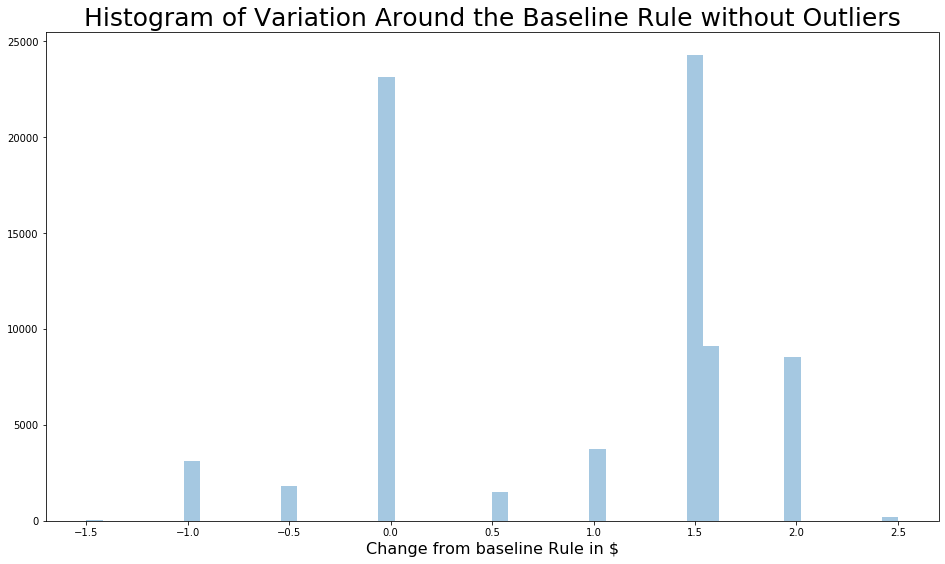

In [187]:
fig = plt.figure(figsize=(16,9))
plot = sns.distplot(penalty_rule[(penalty_rule<=2.5) & (penalty_rule>=-2.5)], kde=False)
plot = plot.get_figure()
plt.xlabel("Change from baseline Rule in $", size =16)
plt.title("Histogram of Variation Around the Baseline Rule without Outliers", size=25)
plot.savefig('baselineVar.png')

In [178]:
dlz_no_penalty = df[df['has_penalty']==False].groupby('case:concept:name')['diff'].max().apply(lambda x : x.days)
dlz_penalty = df[df['has_penalty']].groupby('case:concept:name')['diff'].max().apply(lambda x : x.days)
time_to_penalty = df[df['has_penalty'] & (df['concept:name']=='Add penalty')]['diff'].apply(lambda x : x.days)


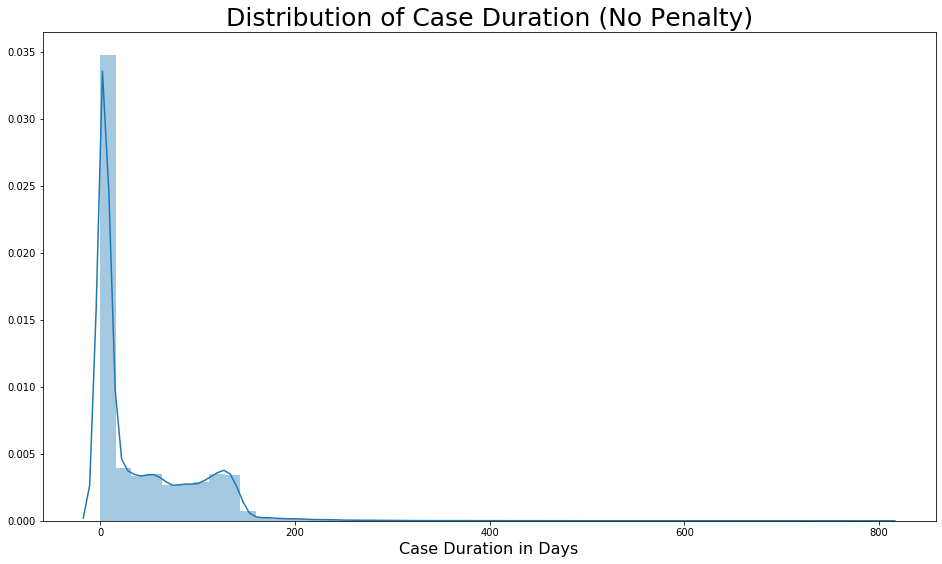

In [186]:
fig = plt.figure(figsize=(16,9))
plot = sns.distplot(dlz_no_penalty[dlz_no_penalty<800])
plot = plot.get_figure()
plt.xlabel("Case Duration in Days", size =16)
plt.title("Distribution of Case Duration (No Penalty)", size=25)
plot.savefig('dlz_no_penalty.png')

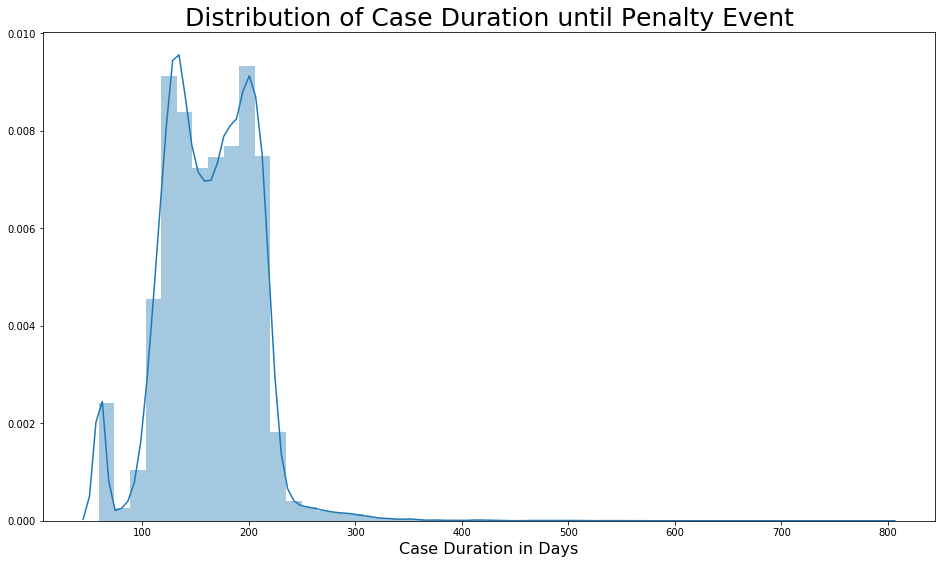

In [188]:
fig = plt.figure(figsize=(16,9))
plot = sns.distplot(time_to_penalty)
plot = plot.get_figure()
plt.xlabel("Case Duration in Days", size =16)
plt.title("Distribution of Case Duration until Penalty Event", size=25)
plot.savefig('time2penalty.png')

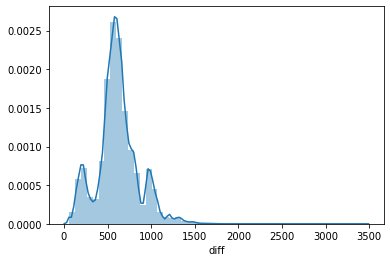

In [152]:
sns.distplot(dlz_penalty)

In [151]:
df[df['has_penalty']==False].groupby('lastEvent')['case:concept:name'].count()

lastEvent
Payment      102539
Send Fine     41860
Name: case:concept:name, dtype: int64

 # c

In [89]:
import seaborn as sns

C:\Users\Sezin\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Sezin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-96-aa4849053268>", line 1, in <module>
    sns.distplot(df[df['has_penalty']]['outcome'])
  File "C:\Users\Sezin\Anaconda3\lib\site-packages\seaborn\distributions.py", line 198, in distplot
    line, = ax.plot(a.mean(), 0)
  File "C:\Users\Sezin\Anaconda3\lib\site-packages\numpy\core\_methods.py", line 163, in _mean
    ret = ret / rcount
TypeError: unsupported operand type(s) for /: 'str' and 'int'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Sezin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, anothe

TypeError: unsupported operand type(s) for /: 'str' and 'int'

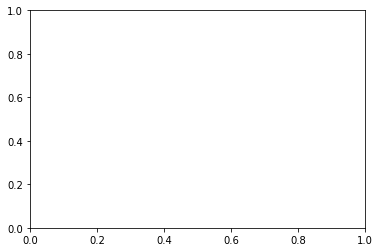

In [96]:
sns.distplot(df[df['has_penalty']]['outcome'])

In [95]:
df[df['has_penalty']].groupby('outcome').count()

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,...,expense,notificationType,lastSent,paymentAmount,lastEvent,starttime,startamount,has_penalty,payed,balance
outcome,,,,,,,,,,,,,,,,,,,,,
exact,138370,69185,69185,351799,69185,85615,351799,351799,69185,69185,...,69185,69185,67836,16430,351799,351799,351799,351799,56640,56640
no,8,4,4,26,4,4,26,26,4,4,...,4,4,3,0,26,26,26,26,26,26
over,522,261,261,1544,261,747,1544,1544,261,261,...,261,261,254,486,1544,1544,1544,1544,1544,1544
some,12106,6053,6053,33978,6053,15761,33978,33978,6053,6053,...,6053,6053,5890,9708,33978,33978,33978,33978,33978,33978


In [142]:
x = df[df['has_penalty']]['outcome']

In [143]:
x.value_counts() / len(x)

exact    0.908227
some     0.087720
over     0.003986
no       0.000067
Name: outcome, dtype: float64

In [144]:
df[df['has_penalty']==False]['outcome'].value_counts() / (len(df)-len(x))

exact    0.698461
no       0.282363
over     0.010277
some     0.008899
Name: outcome, dtype: float64

In [112]:
df[df['has_penalty']==False]['lastEvent'].value_counts()

Payment      102539
Send Fine     41860
Name: lastEvent, dtype: int64

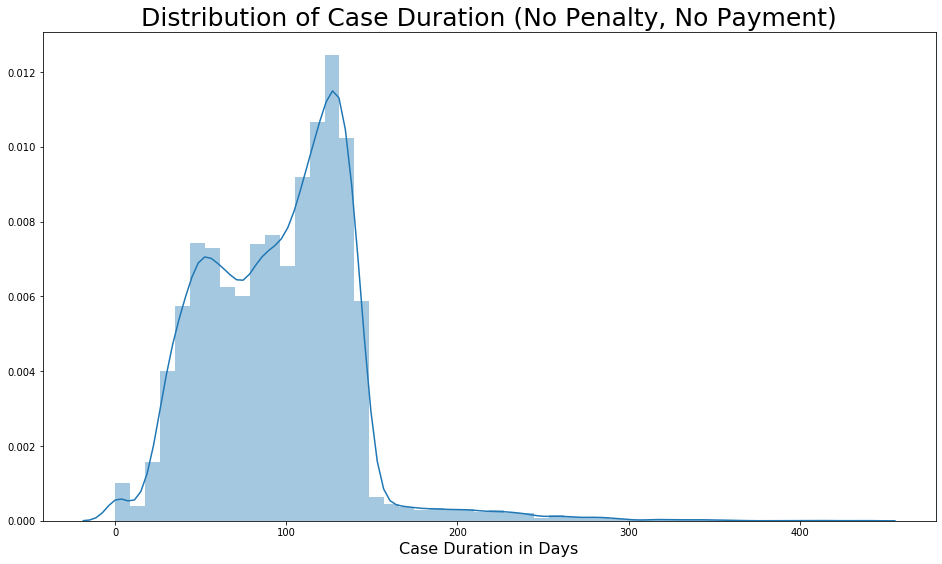

In [189]:
fig = plt.figure(figsize=(16,9))
plot = sns.distplot(df[(df['has_penalty']==False) & (df['lastEvent']=='Send Fine')].groupby('case:concept:name')['diff'].max().apply(lambda x : x.days))
plot = plot.get_figure()
plt.xlabel("Case Duration in Days", size =16)
plt.title("Distribution of Case Duration (No Penalty, No Payment)", size=25)
plot.savefig('no_penalty_send_fine.png')

In [ ]:
df[(df['has_penalty']==False) & (df['lastEvent']=='Send Fine')].groupby('case:concept:name')['diff'].max().apply(lambda x : x.days)

In [145]:
df[(df['has_penalty']==True)][['outcome', 'toPay', 'totalPaymentAmount']]

,outcome,toPay,totalPaymentAmount
2,exact,NaN,0.0
3,exact,NaN,NaN
4,exact,NaN,NaN
5,exact,NaN,NaN
6,exact,NaN,NaN
...,...,...,...
531741,exact,NaN,0.0
531742,exact,NaN,NaN
531743,exact,NaN,NaN
531744,exact,NaN,NaN


In [157]:
fraction_group = df[(df['has_penalty']==True) & (df['outcome']=='some')].groupby('case:concept:name')[['toPay','payed']].max()

In [161]:
(fraction_group['payed'] / fraction_group['toPay']).std()

0.04918619170513486